In [22]:
import matplotlib.pyplot as plt
import os
import seaborn as sns
from sklearn.metrics import confusion_matrix,auc,roc_auc_score, classification_report
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from scipy.stats import multivariate_normal
from sklearn.neighbors import LocalOutlierFactor

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [3]:
#Load Data
df = pd.read_csv("../data/creditcard.csv")

In [86]:
def get_hour_rate(df, hours):
    _ = df[df["Time"]>3600*hours]
    _ = _[_["Time"]<3600*(hours+1)]
    anomalies = _[_["Class"]==1]
    con_rate = anomalies.shape[0]/_.shape[0]
    return con_rate

In [87]:
rate = []
for i in range(48):
    rate.append(get_hour_rate(df, i))

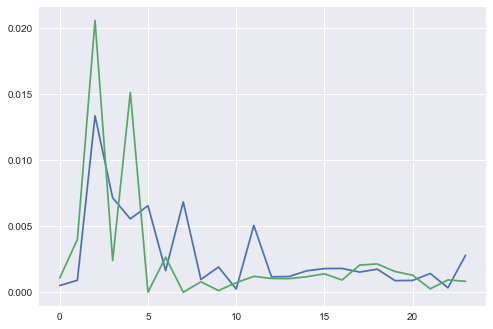

In [88]:
plt.plot(rate[:24])
plt.plot(rate[24:48])

In [89]:
###0.001727485630620034
max(rate)

0.020559680182752713

In [90]:
def get_hour_anomaly(df, hours):
    _ = df[df["Time"]>3600*hours]
    _ = _[_["Time"]<3600*(hours+1)]
    anomalies = _[_["Class"]==1]
    return anomalies.shape[0]
anomaly = []
for i in range(48):
    anomaly.append(get_hour_anomaly(df, i))

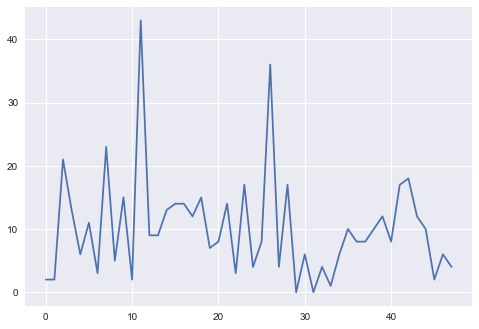

In [91]:
plt.plot(anomaly)

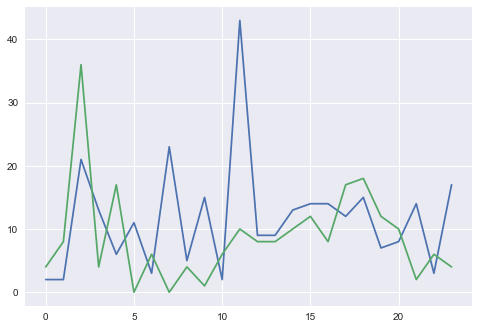

In [92]:
plt.plot(anomaly[:24])
plt.plot(anomaly[24:48])

We get hour data to calculate

In [93]:
def get_hour_df(df, hours):
    _ = df[df["Time"]>3600*hours]
    _ = _[_["Time"]<3600*(hours+1)]
    return _

In [94]:
def get_hour_data(df, hours):
    _ = df[df["Time"]>3600*hours]
    _ = _[_["Time"]<3600*(hours+1)]
    _["Amount"] = _["Amount"]/20
    _["Time"] = _["Time"]/72
    X = _.drop(columns = ['Class']).to_numpy()
    y = _['Class'].to_numpy().flatten()
    return X, y

In [96]:
from sklearn.neighbors import LocalOutlierFactor
y_true =[]
y_pred = np.array([])
factor = []
for i in range(24):
    clf = LocalOutlierFactor(n_neighbors=20, 
                             algorithm='kd_tree', 
                             leaf_size=30, 
                             metric='minkowski',
                             p=2,
                             metric_params=None,
                             contamination=rate[i]*5)
    X, y = get_hour_data(df, i)
    y_true = np.concatenate((y_true, y), axis=None)
    y_pred_temp = clf.fit_predict(X)    
    y_pred = np.concatenate((y_pred, y_pred_temp), axis=None)
    factor.append(clf.negative_outlier_factor_)
    
y_pred[y_pred == 1] = 0 # Valid transactions are labelled as 0.
y_pred[y_pred == -1] = 1 # Fraudulent transactions are labelled as 1.
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_pred,y_true))

[[143201   1263]
 [   139    142]]
              precision    recall  f1-score   support

         0.0       0.99      1.00      1.00    143340
         1.0       0.51      0.10      0.17      1405

    accuracy                           0.99    144745
   macro avg       0.75      0.55      0.58    144745
weighted avg       0.99      0.99      0.99    144745



# Analysis

By projecting F factor and V17 together we can have some insight about how the algorithm perform badly:
    
    The distance calculations takes all dimension equally, which lead to many noises

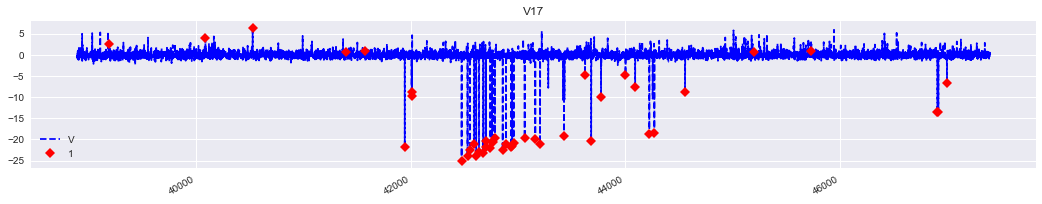

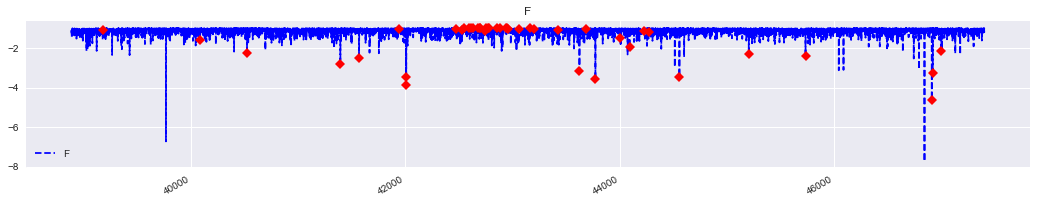

In [134]:
df_ = get_hour_df(df, 11)
df_['F'] = factor[11]
anomalies = df_[df_["Class"]==1]

columns=['V17', 'F']
for col in columns:
    plt.style.use('seaborn')
    plt.figure(figsize=(18,3))
    plt.plot(df_[col], color='blue',linestyle='--', zorder=1)
    plt.plot(anomalies[col], linestyle='none', marker='D', color='red',zorder=2)
    plt.gcf().autofmt_xdate()
    plt.title(col)
    plt.legend(col)
    plt.show()

## Optimization

So the first problem with LocalOutlierFactor is the calculation of distance consider all Variable being equal (for the distance). 

Time and Amount is not normalized variable (the other one are obtained through PCA and seems to have gone through some normalization already so we will not try to change it). 

So the first idea to improve the performance of LOF is normalizing Time and Amount. 

We dont care about the mean because they gonna get subtracted when calculating distance.

Second idea is to use features that have strong relation discover in heuristic method.

Third idea is use smaller time window.

In [127]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.918649e-15,5.682686e-16,-8.761736e-15,2.811118e-15,-1.552103e-15,2.040130e-15,-1.698953e-15,-1.893285e-16,-3.147640e-15,...,1.473120e-16,8.042109e-16,5.282512e-16,4.456271e-15,1.426896e-15,1.701640e-15,-3.662252e-16,-1.217809e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


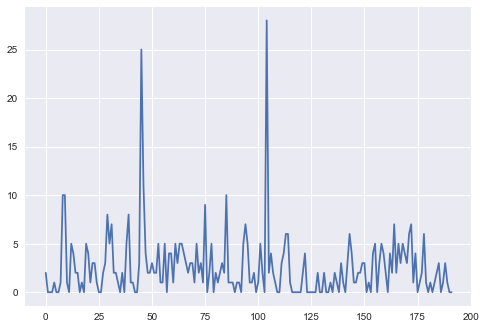

In [128]:
def get_hour_anomaly2(df, hours):
    _ = df[df["Time"]>3600*hours/4]
    _ = _[_["Time"]<3600*(hours+1)/4]
    anomalies = _[_["Class"]==1]
    return anomalies.shape[0]
anomaly2 = []
for i in range(48*4):
    anomaly2.append(get_hour_anomaly2(df, i))
plt.plot(anomaly2)

In [129]:
def get_hour_rate2(df, hours):
    _ = df[df["Time"]>3600*hours/4]
    _ = _[_["Time"]<3600*(hours+1)/4]
    anomalies = _[_["Class"]==1]
    con_rate = anomalies.shape[0]/_.shape[0]
    return con_rate

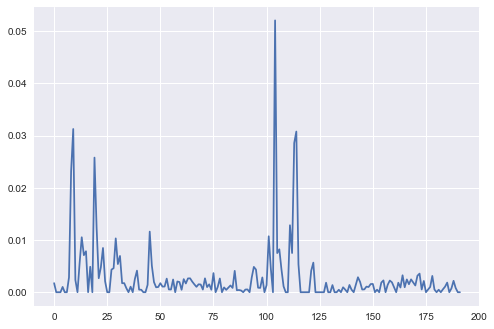

In [142]:
rate2 = []
for i in range(48*4):
    rate2.append(get_hour_rate2(df, i))
plt.plot(rate2)

In [179]:
#['V17', 'V14', 'V12', 'V10', 'V16', 'V11', 'V18']
def get_hour_data2(df, hours):
    _ = df[df["Time"]>3600*hours/4]
    _ = _[_["Time"]<3600*(hours+1)/4]
    _["Amount"] = _["Amount"]/40
    _["Time"] = _["Time"]/3600
    _["V17"] = _["V17"]
    X = _[['V17','V14', 'V12', 'V10', 'V16','Time']].to_numpy()
    y = _['Class'].to_numpy().flatten()
    return X, y

In [180]:
from sklearn.neighbors import LocalOutlierFactor
y_true =[]
y_pred = np.array([])
factor2 = []
for i in range(24*4):
    clf = LocalOutlierFactor(n_neighbors=20, 
                             algorithm='kd_tree', 
                             leaf_size=30, 
                             metric='minkowski',
                             p=2,
                             metric_params=None,
                             contamination= (rate2[i]+rate2[i-1]+rate2[i+1]+0.0001)/2)
    X, y = get_hour_data2(df, i)
    y_true = np.concatenate((y_true, y), axis=None)
    y_pred_temp = clf.fit_predict(X)    
    y_pred = np.concatenate((y_pred, y_pred_temp), axis=None)
    factor2.append(clf.negative_outlier_factor_)
y_pred[y_pred == 1] = 0 # Valid transactions are labelled as 0.
y_pred[y_pred == -1] = 1 # Fraudulent transactions are labelled as 1.
print(confusion_matrix(y_true, y_pred))
print(classification_report(y_pred,y_true))

[[144059    285]
 [    87    194]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    144146
         1.0       0.69      0.41      0.51       479

    accuracy                           1.00    144625
   macro avg       0.84      0.70      0.75    144625
weighted avg       1.00      1.00      1.00    144625



## Local Outlier Factor Analysis

In [171]:
def get_hour_df2(df, hours):
    _ = df[df["Time"]>3600*hours/4]
    _ = _[_["Time"]<3600*(hours+1)/4]
    return _

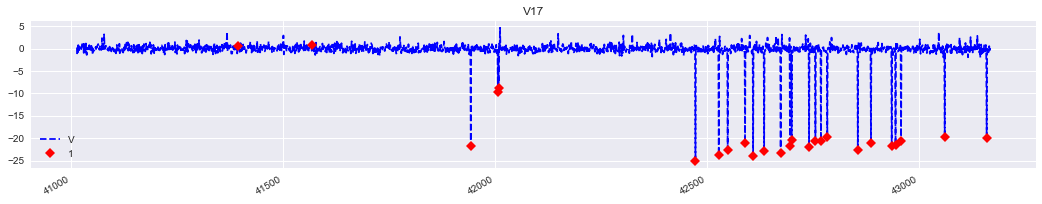

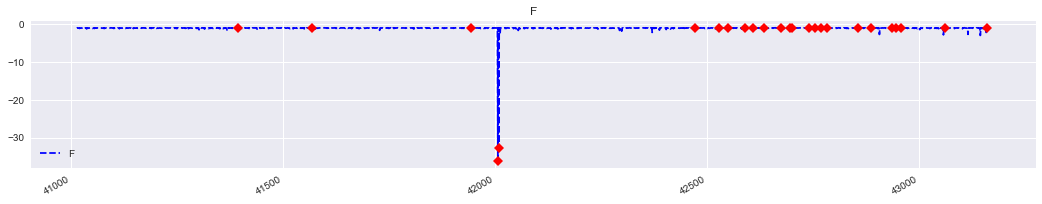

In [172]:
df_ = get_hour_df2(df, 45)
df_['F'] = factor2[45]
anomalies = df_[df_["Class"]==1]

columns=['V17', 'F']
for col in columns:
    plt.style.use('seaborn')
    plt.figure(figsize=(18,3))
    plt.plot(df_[col], color='blue',linestyle='--', zorder=1)
    plt.plot(anomalies[col], linestyle='none', marker='D', color='red',zorder=2)
    plt.gcf().autofmt_xdate()
    plt.title(col)
    plt.legend(col)
    plt.show()

In [176]:
factor2[45][np.argsort(factor2[45])]

array([-36.21946313, -32.66667204,  -2.98078155, ...,  -0.9524232 ,
        -0.95190593,  -0.94564143])

In [175]:
np.argsort(factor2[45])

array([ 993,  995, 2131, ..., 1107,  812, 1273], dtype=int64)